In [ ]:
# change padding from 81 to 28885
# Ask Zac which words to remove (shortest word cut off line)
# dimensions are not 128 but they are when you make it with torch

In [87]:
import tensorflow as tf
# tf.config.list_physical_devices('GPU') is not with GPU
tf.test.is_built_with_cuda()

print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)

tf version:  2.8.0
tf.keras version: 2.8.0


In [127]:
from numpy import array
from scipy import stats
import numpy as np, pandas as pd
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm

In [128]:
%store -r ema_frames
# del ema_frames[2874]

In [180]:
# convert raw audio to mel_spectogram
def logmelfilterbank(audio,
                     sampling_rate,
                     fft_size=1024,
                     hop_size=256,
                     win_length=None,
                     window="hann",
                     num_mels=80,
                     fmin=None,
                     fmax=None,
                     eps=1e-10,
                     ):
    ''' essentially the same as librosa.feature.melspectrogram + log10 '''

    # get amplitude spectrogram
    x_stft = librosa.stft(audio, n_fft=fft_size, hop_length=hop_size,
                          win_length=win_length, window=window, pad_mode="reflect")
    spc = np.abs(x_stft).T  # (#frames, #bins)

    # get mel basis
    fmin = 0 if fmin is None else fmin
    fmax = sampling_rate / 2 if fmax is None else fmax
    mel_basis = librosa.filters.mel(sampling_rate, fft_size, num_mels, fmin, fmax)

    return np.log10(np.maximum(eps, np.dot(spc, mel_basis.T)))

In [220]:
waveform = ema_frames[0]['Audio'][0][0].values
sr = 22050

spectrogram_torch = librosa.feature.melspectrogram(y=waveform, sr=sr)
spectrogram_torch = torch.from_numpy(spectrogram_torch) # somehow this lines makes it into 128

spectogram_yulia = logmelfilterbank(waveform, sr)

C:\Users\nchau\anaconda3\envs\env_pytorch\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Pass sr=22050, n_fft=1024, n_mels=80, fmin=0, fmax=11025.0 as keyword args. From version 0.10 passing these as positional arguments will result in an error


In [221]:
print(spectrogram_torch.shape)
print(spectogram_yulia.shape)

torch.Size([128, 7])
(13, 80)


In [131]:
# get longest and shortest mel spectogram array length >> 28885
def get_arr_length(ema_list):
    """Loads data and tracks longest mel spectogram array
    :return counter: the longest length of array
    """
    counter_longest = 0
    counter_shortest = 3000 # arbritary number
    shapes = []
    
    for i in ema_list:
        mel_array = i['Mel'][0] # is array
        shapes.append(mel_array.shape[0])
        
        if mel_array.shape[0] > counter_longest:
            counter_longest = mel_array.shape[0]    
            
        elif mel_array.shape[0] < counter_shortest:
            counter_shortest = mel_array.shape[0]
            
    return counter_longest, counter_shortest, shapes
 
longest_mel, shortest_mel, shapes_list = get_arr_length(ema_frames) # 28885 1102

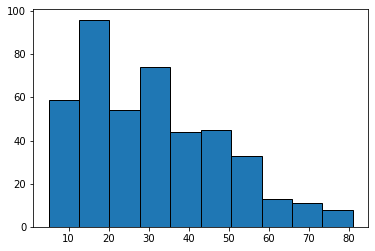

In [136]:
# Explore spread of dataset
list_array = np.array(shapes_list)
description = stats.describe(list_array)

#create histogram with 4 bins
plt.hist(shapes_list, bins=None, edgecolor='black'); # ';' removes array at the end

In [140]:
def prepare_dataframe(ema_list):
    df = pd.DataFrame(columns=['Input', 'Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5', 'Label 6',
                              'Label 7', 'Label 8', 'Label 9', 'Label 10', 'Label 11', 'Label 12'])
    
    for i in range(len(ema_list)):
        mel_arr = librosa.util.fix_length(ema_list[i]['Mel'][0], size=81) # add padding
        
        ema_columns = ['ul_0', 'ul_1', 'll_0', 'll_1', 'jw_0', 'jw_1', 'tt_0', 'tt_1', 'tb_0', 'tb_1', 'td_0', 'td_1']
        ema_markers = ema_list[i]['Data'][0].loc[:, ema_columns]
        ema_arr = (ema_markers.to_numpy()).T
        
        df = df.append({'Input': mel_arr, 'Label 1': ema_arr[0], 'Label 2': ema_arr[1], 'Label 3': ema_arr[2], 
                        'Label 4': ema_arr[3], 'Label 5': ema_arr[4], 'Label 6': ema_arr[5], 'Label 7': ema_arr[6], 
                        'Label 8': ema_arr[7], 'Label 9': ema_arr[8], 'Label 10': ema_arr[9], 'Label 11': ema_arr[10], 
                        'Label 12': ema_arr[11]}, ignore_index=True)
        
    return df

df = prepare_dataframe(ema_frames)

In [223]:
def add_new_col(ema_list):
    df1 = pd.DataFrame(columns=['Input', 'Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5', 'Label 6',
                              'Label 7', 'Label 8', 'Label 9', 'Label 10', 'Label 11', 'Label 12'])
    
    
    for i in range(len(ema_list)):
        waveform = ema_frames[i]['Audio'][0][0].values
        spectrogram_torch = librosa.feature.melspectrogram(y=waveform, sr=22050)
        spectrogram_torch = librosa.util.fix_length(spectrogram_torch, size=81)
        spectrogram_torch = torch.from_numpy(spectrogram_torch)
        
        ema_columns = ['ul_0', 'ul_1', 'll_0', 'll_1', 'jw_0', 'jw_1', 'tt_0', 'tt_1', 'tb_0', 'tb_1', 'td_0', 'td_1']
        ema_markers = ema_list[i]['Data'][0].loc[:, ema_columns]
        ema_arr = (ema_markers.to_numpy()).T
        
        df1 = df1.append({'Input': spectrogram_torch, 'Label 1': ema_arr[0], 'Label 2': ema_arr[1], 'Label 3': ema_arr[2], 
                        'Label 4': ema_arr[3], 'Label 5': ema_arr[4], 'Label 6': ema_arr[5], 'Label 7': ema_arr[6], 
                        'Label 8': ema_arr[7], 'Label 9': ema_arr[8], 'Label 10': ema_arr[9], 'Label 11': ema_arr[10], 
                        'Label 12': ema_arr[11]}, ignore_index=True)
        
        
    return df1

df1 = add_new_col(ema_frames)

In [224]:
df.loc[0,:][0].shape

(13, 81)

In [225]:
df1.loc[0,:][0].shape

torch.Size([128, 81])

In [230]:
X = []
y = []

for data in tqdm(df1.iterrows(), desc='Progress'):
    X.append(data[1][0])
    y.append(data[1][1])

Progress: 437it [00:00, 1255.04it/s]


In [243]:
df1.iloc[:,0]

KeyboardInterrupt: 

In [236]:
X.shape

AttributeError: 'list' object has no attribute 'shape'

In [114]:
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers

In [116]:
X_train , X_test , y_train , y_test = train_test_split(X , y ,test_size=0.2, random_state=42)

INPUTSHAPE = (28885,1)

In [117]:
model =  models.Sequential([
                          layers.Conv2D(32 , (3,3),activation = 'relu',padding='valid', input_shape = INPUTSHAPE),  
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Dropout(0.3),
                          layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Dropout(0.3),
                          layers.GlobalAveragePooling2D(),
                          layers.Dense(512 , activation = 'relu'),
                          layers.Dense(50 , activation = 'softmax')
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'acc')
model.summary()

ValueError: Input 0 of layer conv2d is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (None, 28885, 1)

In [ ]:
https://www.kaggle.com/code/volkandl/audio-processing-features-cnn-training